In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
deliv_times = pd.read_csv('historical_data.csv')
deliv_times.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
deliv_times.created_at = pd.to_datetime(deliv_times.created_at)
deliv_times.actual_delivery_time = pd.to_datetime(deliv_times.actual_delivery_time)
total_duration = deliv_times.actual_delivery_time - deliv_times.created_at
total_duration = pd.to_timedelta(total_duration).dt.total_seconds()

In [4]:
deliv_times = deliv_times.query('total_busy_dashers >= 0 & total_onshift_dashers>=total_busy_dashers')
deliv_times['busy_dashers_ratio'] = deliv_times.total_busy_dashers / (deliv_times.total_onshift_dashers)
deliv_times['busy_dashers_ratio'] = deliv_times['busy_dashers_ratio'].replace({np.nan:1})

In [5]:
unique_ids = deliv_times.store_id.unique()
most_common_cuisines = {id:deliv_times[id == deliv_times.store_id].store_primary_category.mode() for id in unique_ids}

In [6]:
def fill(id):
    try:
        return most_common_cuisines[id].values[0]
    except:
        return np.nan
    
deliv_times['nan-free_store_category'] = deliv_times.store_id.apply(fill)


In [7]:
mkt_ids = pd.get_dummies(deliv_times['market_id'],dtype= float)
mkt_ids= mkt_ids.add_prefix('market_id_')
orderprotocols = pd.get_dummies(deliv_times['order_protocol'],dtype = float)
orderprotocols = orderprotocols.add_prefix('protocol_')
cuisines = pd.get_dummies(deliv_times['nan-free_store_category'],dtype = float)
cuisines = cuisines.add_prefix('category_')

In [8]:
deliv_times = pd.concat([deliv_times,mkt_ids,orderprotocols,cuisines],axis=1)
deliv_times.dropna(inplace=True)

In [9]:
deliv_times.drop(columns=['market_id','store_id','created_at','actual_delivery_time','order_protocol','store_primary_category','nan-free_store_category','total_onshift_dashers','total_busy_dashers'],inplace=True)

In [10]:
corrmatrix = deliv_times.corr()
mask = np.triu(np.ones_like(corrmatrix,dtype=bool))

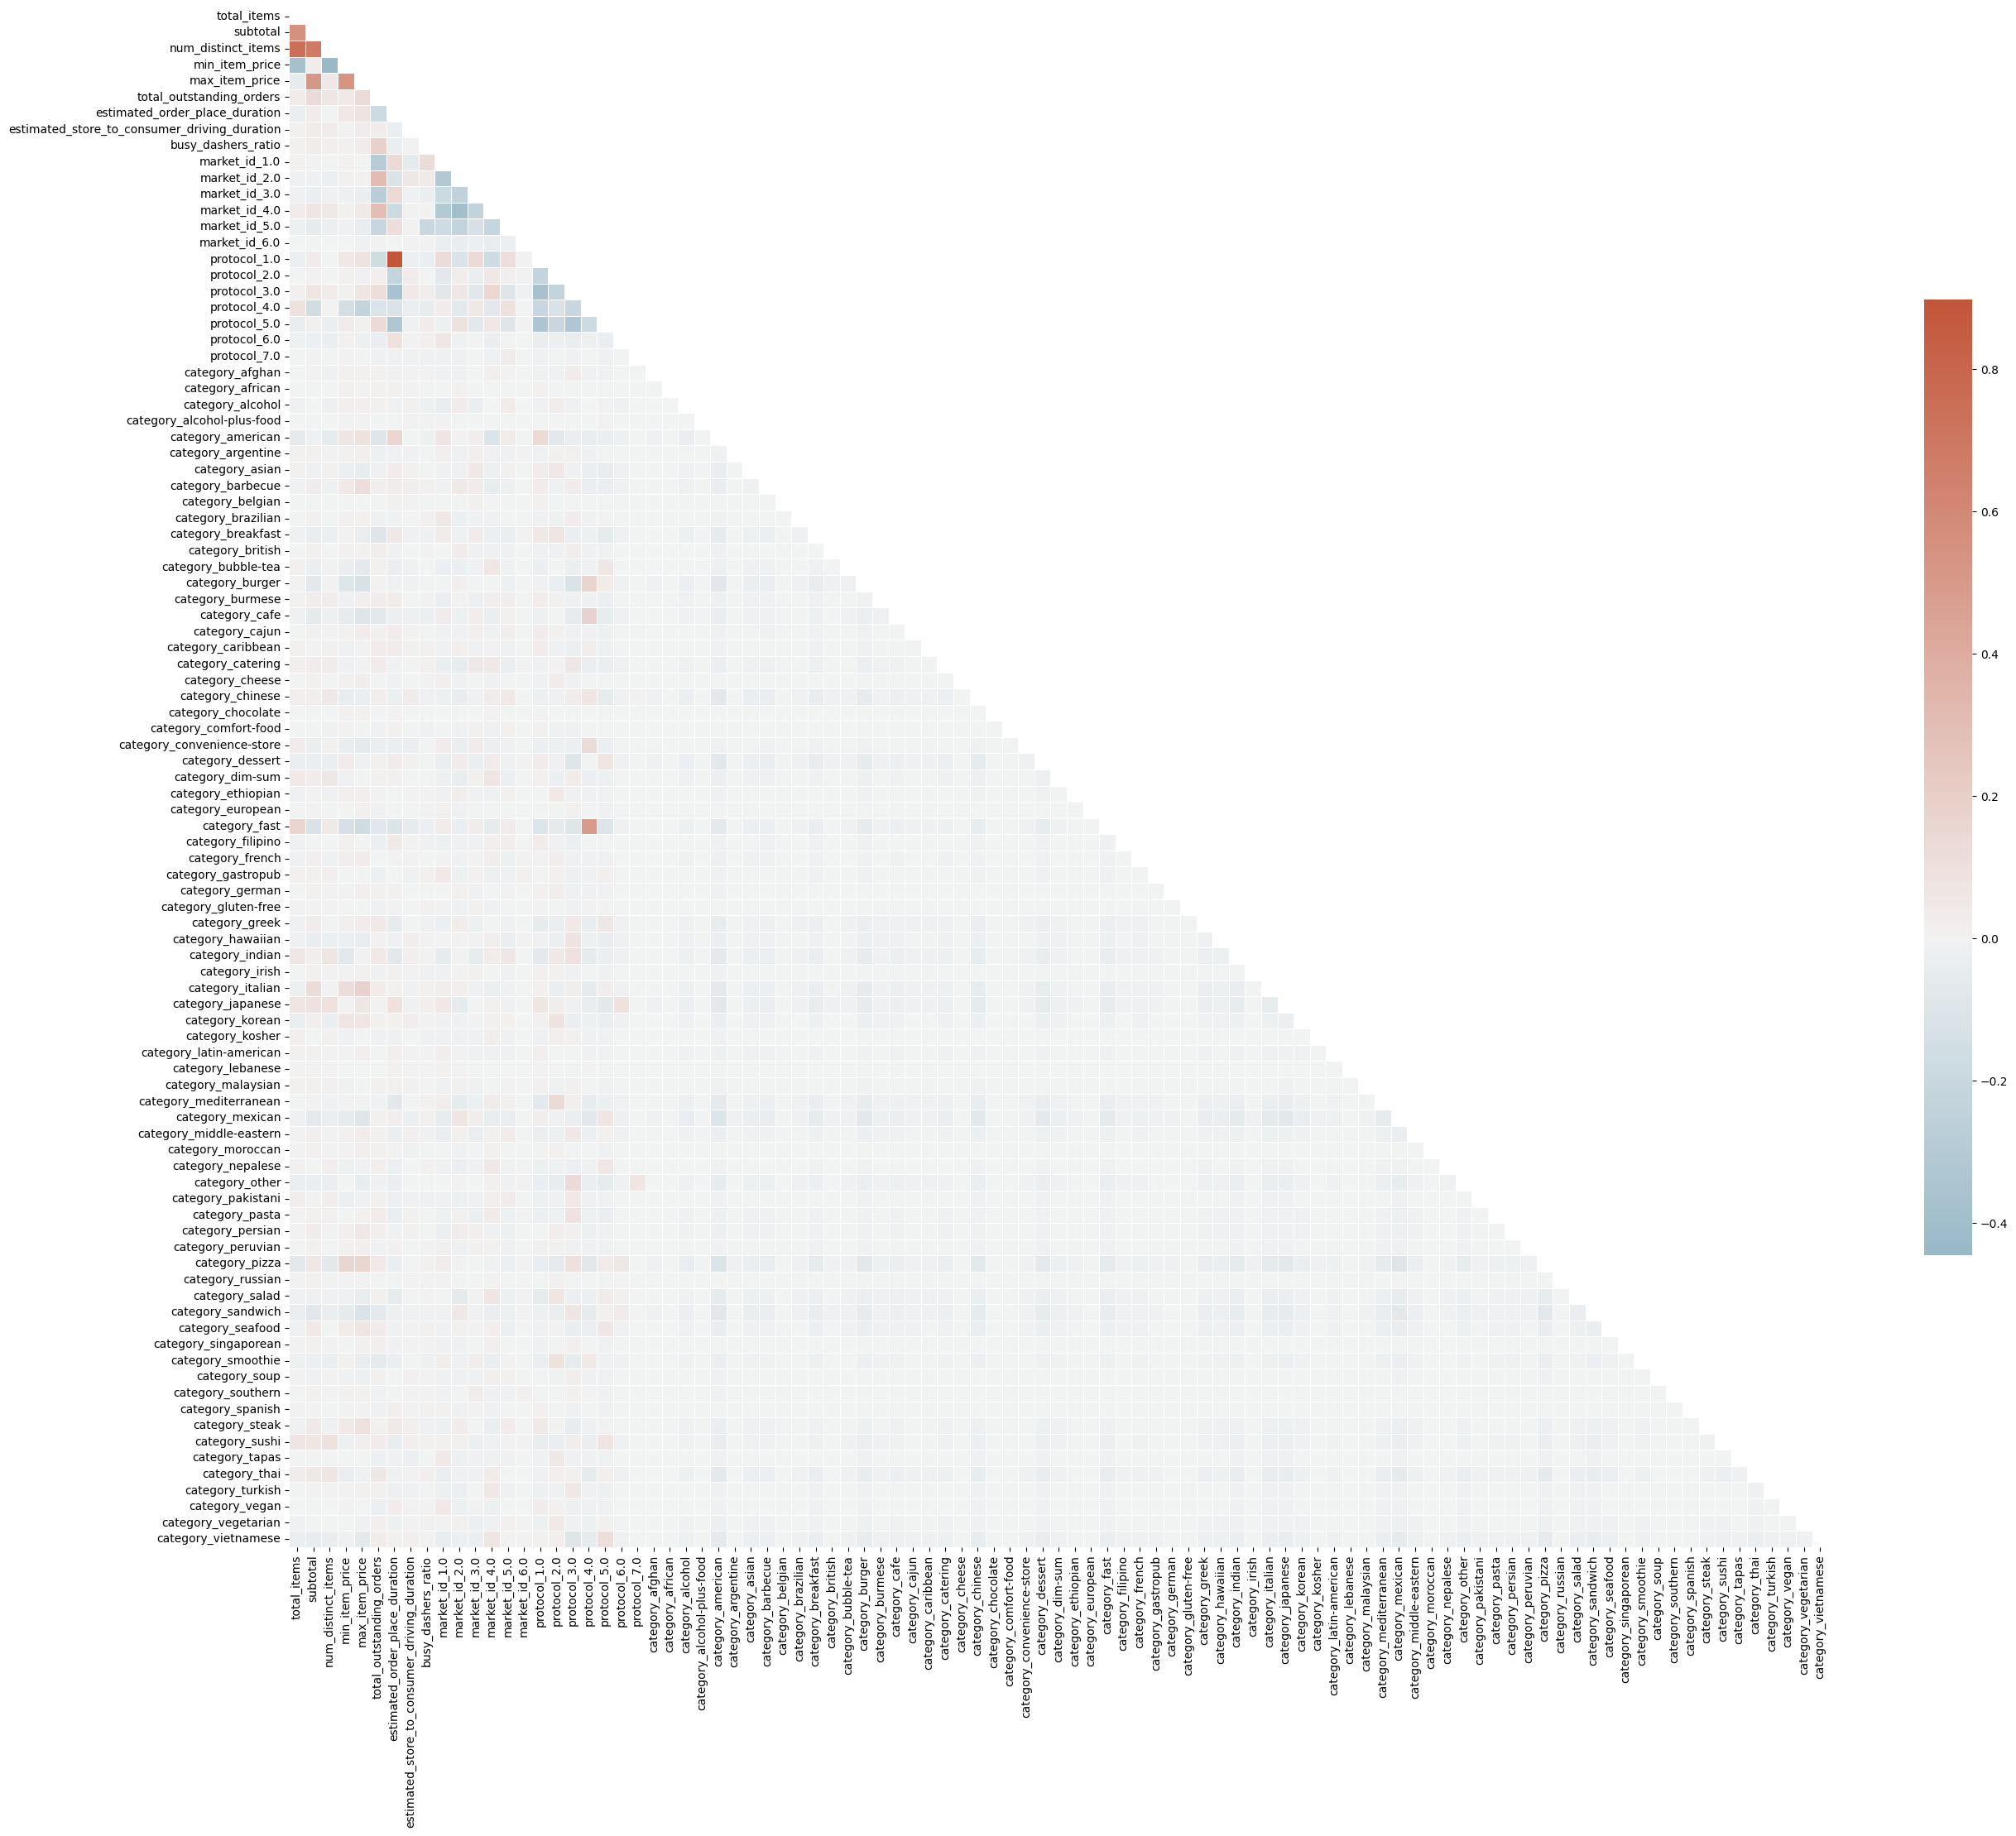

In [11]:
f,ax = plt.subplots(figsize =(30,30))
cmap = sns.diverging_palette(230,20, as_cmap=True)
sns.heatmap(corrmatrix,mask=mask,cmap=cmap,square=True,center=0,linewidths=0.5,cbar_kws={"shrink":0.5})
plt.show()


In [13]:
deliv_times.shape

(136467, 95)

In [12]:
def get_redundant_pairs(df):
    pairs_to_drop =set()
    cols = df.columns
    for i in range(df.shape[1]):
        for j in range(i+1):
            pairs_to_drop.add((cols[i],cols[j]))
    return pairs_to_drop

In [14]:
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [18]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(deliv_times, 20))

Top Absolute Correlations
subtotal                        distinct_items_ratio              0.203330
total_outstanding_orders        busy_dashers_ratio                0.187214
                                estimated_order_place_duration    0.184560
category_fast                   distinct_items_ratio              0.152783
estimated_order_place_duration  category_american                 0.147974
subtotal                        total_outstanding_orders          0.137995
                                category_italian                  0.123770
                                category_fast                     0.123378
estimated_order_place_duration  category_fast                     0.109457
category_american               category_pizza                    0.104713
                                category_mexican                  0.103640
category_mexican                category_pizza                    0.095153
estimated_order_place_duration  category_japanese                 0.092909

In [16]:
deliv_times.drop(columns=['market_id_1.0','market_id_2.0','market_id_3.0','market_id_4.0','market_id_5.0','market_id_6.0','protocol_1.0','protocol_2.0','protocol_3.0','protocol_4.0','protocol_5.0','protocol_6.0','protocol_7.0'],inplace=True)

In [17]:
deliv_times['distinct_items_ratio'] = deliv_times['num_distinct_items']/deliv_times['total_items']
deliv_times.drop(columns=['min_item_price','max_item_price','num_distinct_items','total_items'],inplace=True)

In [47]:
def compute_vif(df):
    vif = pd.DataFrame()
    vif['features'] = pd.Series(df.columns)
    vif['VIF_values'] = [variance_inflation_factor(df.values,i) for i in range(len(df.columns))]
    return vif.sort_values(by='VIF_values').reset_index(drop=True)

In [48]:
vifvals = compute_vif(deliv_times)

In [49]:
vifvals.query('VIF_values > 5')

,features,VIF_values
72,category_sandwich,5.007661
73,category_japanese,5.020745
74,category_chinese,5.121891
75,category_burger,5.296669
76,category_mexican,7.627627
77,category_pizza,8.226659
78,category_american,9.593842
